In [1]:
# Install TensorFlow, a popular machine learning library
!pip install tensorflow

# Install the Transformers library, which provides pre-trained models for natural language processing tasks
!pip install transformers

# Install pandas, a data manipulation library
!pip install pandas

# Import the pandas library and alias it as pd for convenience
import pandas as pd

# Import TensorFlow and alias it as tf for convenience
import tensorflow as tf

# Import the BertTokenizer and TFBertForSequenceClassification classes from the Transformers library
from transformers import BertTokenizer, TFBertForSequenceClassification

# Import train_test_split function from scikit-learn for splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# Import LabelEncoder from scikit-learn for encoding categorical labels into numerical values
from sklearn.preprocessing import LabelEncoder



In [2]:
# Load your custom dataset from a CSV file
# Replace 'Dataset_NLP.csv' with the path to your CSV file
df = pd.read_csv('Dataset_NLP.csv')

# Assuming your CSV has 'posts' and 'type' columns
# Extract the 'posts' column as a list of texts and the 'type' column as a list of labels
texts = df['posts'].tolist()
labels = df['type'].tolist()

# Encode labels
# Create a LabelEncoder instance to convert categorical labels into numerical values
label_encoder = LabelEncoder()
# Fit the encoder on the list of labels and transform them into numerical values
encoded_labels = label_encoder.fit_transform(labels)


In [3]:
# Split the data into training and testing sets
# Use train_test_split from scikit-learn to create training and testing sets with 80% for training and 20% for testing
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, encoded_labels, test_size=0.2, random_state=42)

# Load BERT tokenizer and model
# Load the pre-trained BERT tokenizer and model from the 'bert-base-uncased' version
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(encoded_labels)))

# Tokenize the input texts
# Use the BERT tokenizer to convert the input texts into tokens, with truncation, padding, and a maximum length of 128 tokens
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors='tf')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors='tf')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Create TensorFlow datasets
# Create TensorFlow datasets from the tokenized encodings and labels, shuffle the training dataset, and batch both datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(100).batch(2)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(2)

# Fine-tune BERT for text classification
# Define an Adam optimizer with a specified learning rate for fine-tuning BERT
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
# Define the sparse categorical crossentropy loss function for the classification task
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Define a metric for tracking accuracy during training
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')


In [6]:
# Compile the model
# Configure the model for training by specifying the optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
# Fit the model on the training dataset for a specified number of epochs, using the validation dataset for validation during training
# Train the model and capture the training history
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

# Evaluate the model
# Evaluate the trained model on the test dataset and print the evaluation results
model.evaluate(test_dataset)



Epoch 1/10
404/404 [==============================] - 1722s 4s/step - loss: 2.2857 - accuracy: 0.2068 - val_loss: 2.2311 - val_accuracy: 0.2772
Epoch 2/10
404/404 [==============================] - 1692s 4s/step - loss: 2.2300 - accuracy: 0.2416 - val_loss: 2.2532 - val_accuracy: 0.1931
Epoch 3/10
404/404 [==============================] - 1657s 4s/step - loss: 2.1260 - accuracy: 0.3271 - val_loss: 2.2431 - val_accuracy: 0.2574
Epoch 4/10
404/404 [==============================] - 1623s 4s/step - loss: 1.7496 - accuracy: 0.4560 - val_loss: 2.4331 - val_accuracy: 0.3069
Epoch 5/10
404/404 [==============================] - 1621s 4s/step - loss: 1.2928 - accuracy: 0.6208 - val_loss: 2.7452 - val_accuracy: 0.2673
Epoch 6/10
404/404 [==============================] - 1621s 4s/step - loss: 0.7920 - accuracy: 0.7807 - val_loss: 2.9578 - val_accuracy: 0.2525
Epoch 7/10
404/404 [==============================] - 1627s 4s/step - loss: 0.5253 - accuracy: 0.8563 - val_loss: 3.2863 - val_accuracy:

[3.86968731880188, 0.18316832184791565]

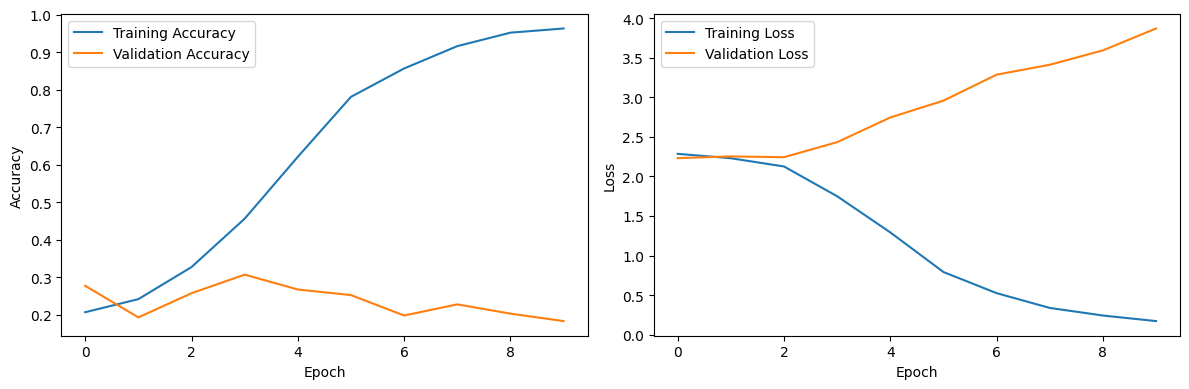

In [7]:
# Plot accuracy and loss curves
import matplotlib.pyplot as plt

# Access training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()